In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import pandas as pd
import os
import sys
sys.path.insert(0,'../code/data_utils/SampleClass/')
from Coordinates import Coordinates
sys.path.insert(1,'../code/data_utils/')
from ConfigDataset import ConfigDataset
plt.style.use('/home/gridsan/gschuette/universal/matplotlib/plot_style_2.txt')

In [2]:
config_fp = '../data/processed_data.hdf5'
num_bins = 64
resolution = 20_000
mean_dist_fp = '../data/mean_dists.pt'
mean_sq_dist_fp='../data/squares.pt'

save_dir = './maps_vs_tan/'

cond_scale = 5.0
rescaled_phi = 8.0
milestone = 120
resolution = 20_000

regions = { # chrom:region_idxs
  '1':[144,200,265,330,395,460,525,590,730,795,860,1260,1325], 
  'X':[100,236,381,445,553,610,675,810,900,965,1060,1125,1200]
}

Load the Dip-C coordinates

In [3]:
config_ds = ConfigDataset(
    config_fp,
    segment_length=num_bins,
    remove_diagonal=False,
    batch_size=0,
    normalize_distances=False,
    geos=None,
    organisms=None,
    cell_types=None,
    cell_numbers=None,
    chroms=[chrom for chrom in regions],
    replicates=None,
    shuffle=False,
    allow_overlap=True,
    two_channels=False,
    try_GPU=False,
    mean_dist_fp=mean_dist_fp,
    mean_sq_dist_fp=mean_sq_dist_fp
)
rosetta = pd.read_pickle(f'../data/embeddings_{num_bins}_after_transformer/rosetta_stone.pkl')
config_directory = '../data/samples/origami_64_no_embed_reduction/eval_mode/'

Support functions

In [4]:
def get_genomic_index(chrom,region_idx,rosetta=rosetta):
    return rosetta[chrom][region_idx][-1]

In [5]:
def get_gen_dists(filepath,chrom,region_idx,cond_scale,rescaled_phi,milestone):
    if filepath is None:
        filepath = config_directory + f'/sample_{region_idx}_{float(cond_scale)}_{float(rescaled_phi)}_{milestone}_{chrom}.pt'
    gen_configs = torch.load(filepath)
    gen_configs = gen_configs[gen_configs.isfinite().all(-1).all(-1)]
    if gen_configs.shape[-1] == 3:
        gen_configs = Coordinates(gen_configs).distances
    else:
        gen_configs = Distances(gen_configs)
    return gen_configs.float_().cpu_()

In [6]:
def get_tan_dists(chrom,region_idx,config_ds=config_ds):
    chrom = str(chrom)
    start_idx = get_genomic_index(chrom,region_idx) # Get starting position by bp position
    return Coordinates(config_ds.fetch_specific_coords(chrom=chrom,start_idx=start_idx)[1]).distances.float_().cpu_(), start_idx

Plotting function

In [7]:
def gen_vs_tan(
    chrom=None,
    region_idx=None,
    config_directory=config_directory,
    *,
    gen_configs = None,
    tan_configs = None,
    filepath=None,
    cond_scale=cond_scale,
    rescaled_phi=rescaled_phi,
    milestone=milestone,
    resolution=20_000
):

    if gen_configs is None:
        gen_configs = get_gen_dists(filepath,chrom,region_idx,cond_scale,rescaled_phi,milestone)
    gen_mean = gen_configs.mean
    gen_std = gen_configs.std
    del gen_configs

    if tan_configs is None:
        tan_configs, genomic_index = get_tan_dists(chrom,region_idx)
    else:
        genomic_index = get_genomic_index(chrom,region_idx)
    tan_mean = tan_configs.mean
    tan_std = tan_configs.std
    del tan_configs

    fig = plt.figure(figsize=(6.5,2.1))
    
    dist_ax = fig.add_subplot(121)
    _,_,dist_im,dist_cbar = tan_mean.plot_with(gen_mean,fig=fig,ax=dist_ax)

    std_ax = fig.add_subplot(122)
    _,_,std_im,std_cbar = tan_std.plot_with(gen_std,fig=fig,ax=std_ax)

    n = tan_mean.num_beads
    fig.suptitle(
        #'Distance Statistics Comparison:\n'+\
        f'Chromosome {chrom}: {genomic_index:,}-{genomic_index+resolution*n:,}'
    )

    for ax in [dist_ax,std_ax]:
        
        ax.text(.995*n-1,.005*n,'Dip-C',horizontalalignment='right',verticalalignment='top',
                color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])
        
        ax.text(.005*n,.995*n-1,'Generated',horizontalalignment='left',verticalalignment='baseline',
                color='black',path_effects=[pe.withStroke(linewidth=1, foreground="white")])

    return fig, dist_ax, dist_im, dist_cbar, std_ax, std_im, std_cbar
    

Make all of the plots

In [8]:
if save_dir == '':
    save_dir = './'
if save_dir[-1] != '/':
    save_dir+= '/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 35 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'D', 'G', 'I', 'M', 'S', 'a', 'c', 'colon', 'comma', 'd', 'e', 'eight', 'four', 'h', 'hyphen', 'i', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'r', 's', 'six', 'space', 't', 'three', 'two', 'v', 'x', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 20, 21, 22, 23, 25, 27, 28, 29, 38, 39, 42, 44, 48, 54, 68, 70, 71, 72, 75, 76, 80, 81, 82, 85, 86, 87, 89, 91]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 35 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'D', 'G', 'I'

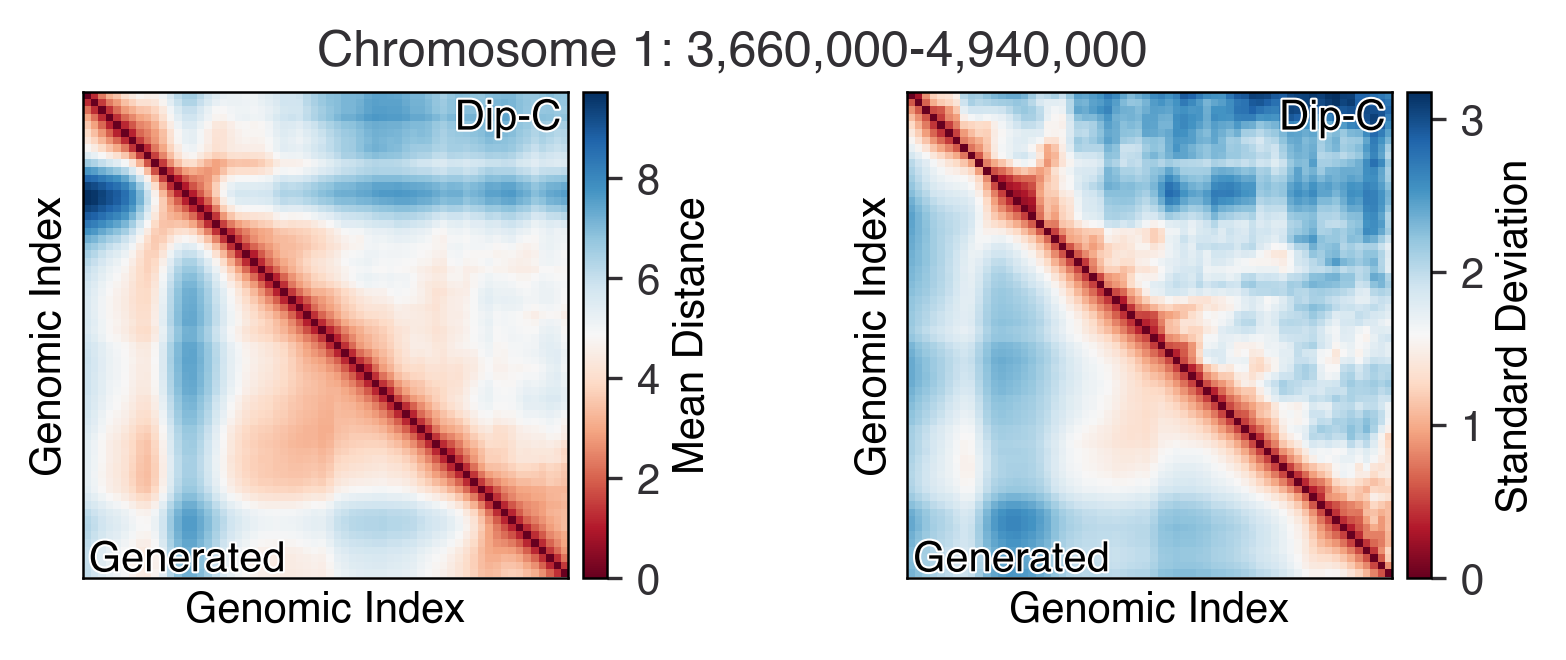

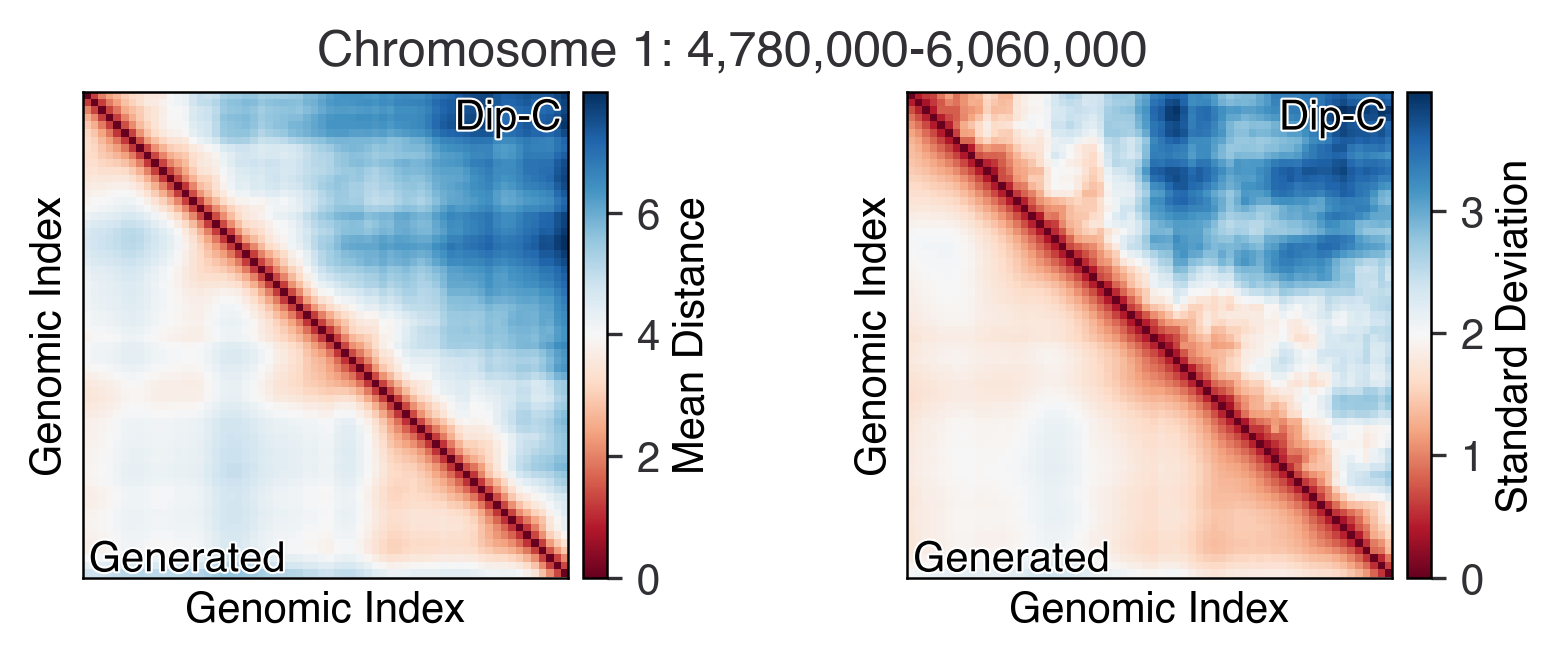

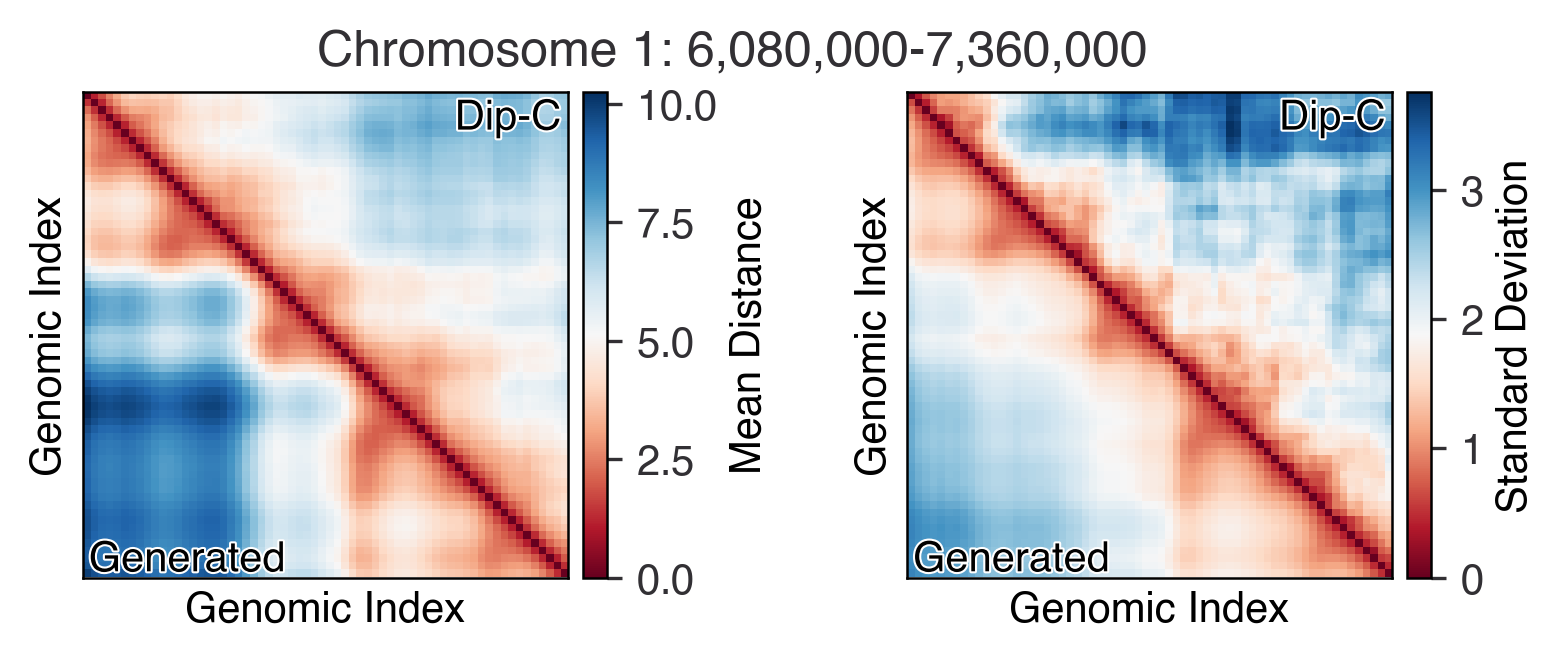

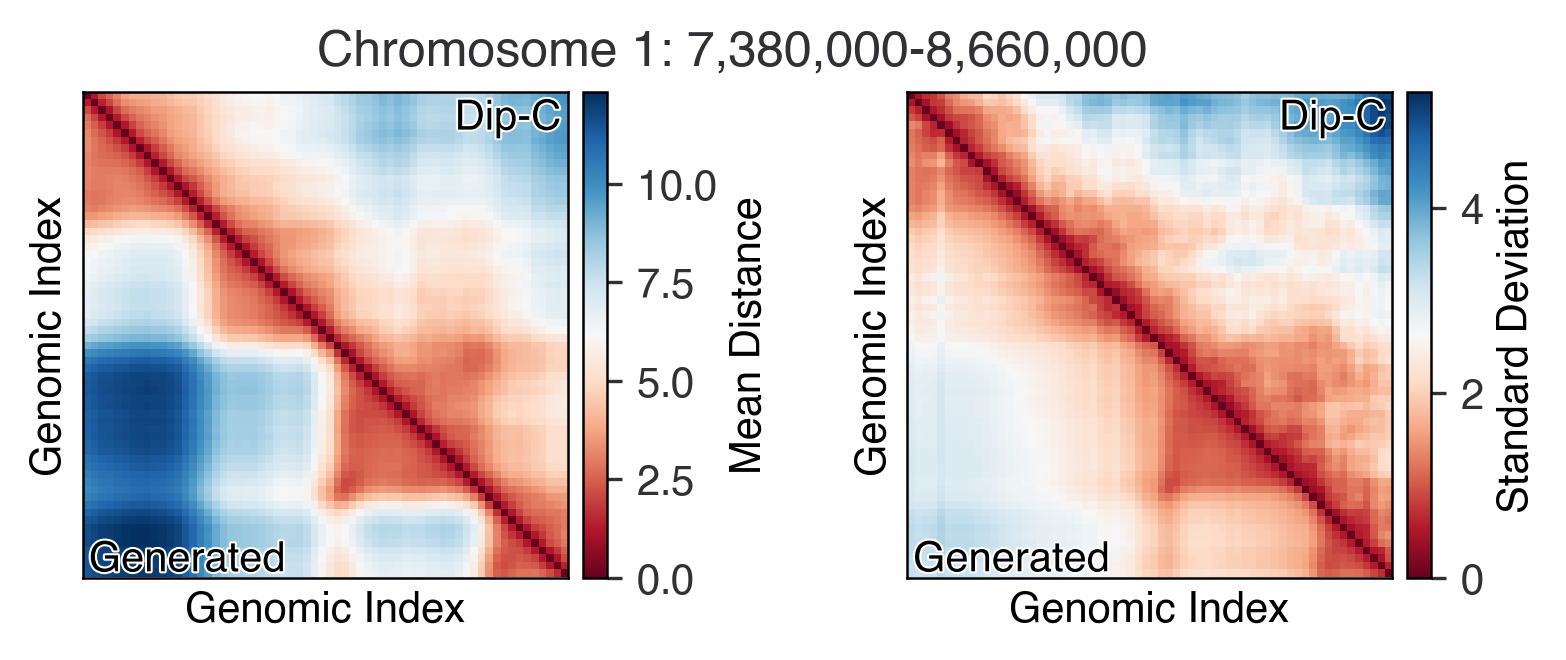

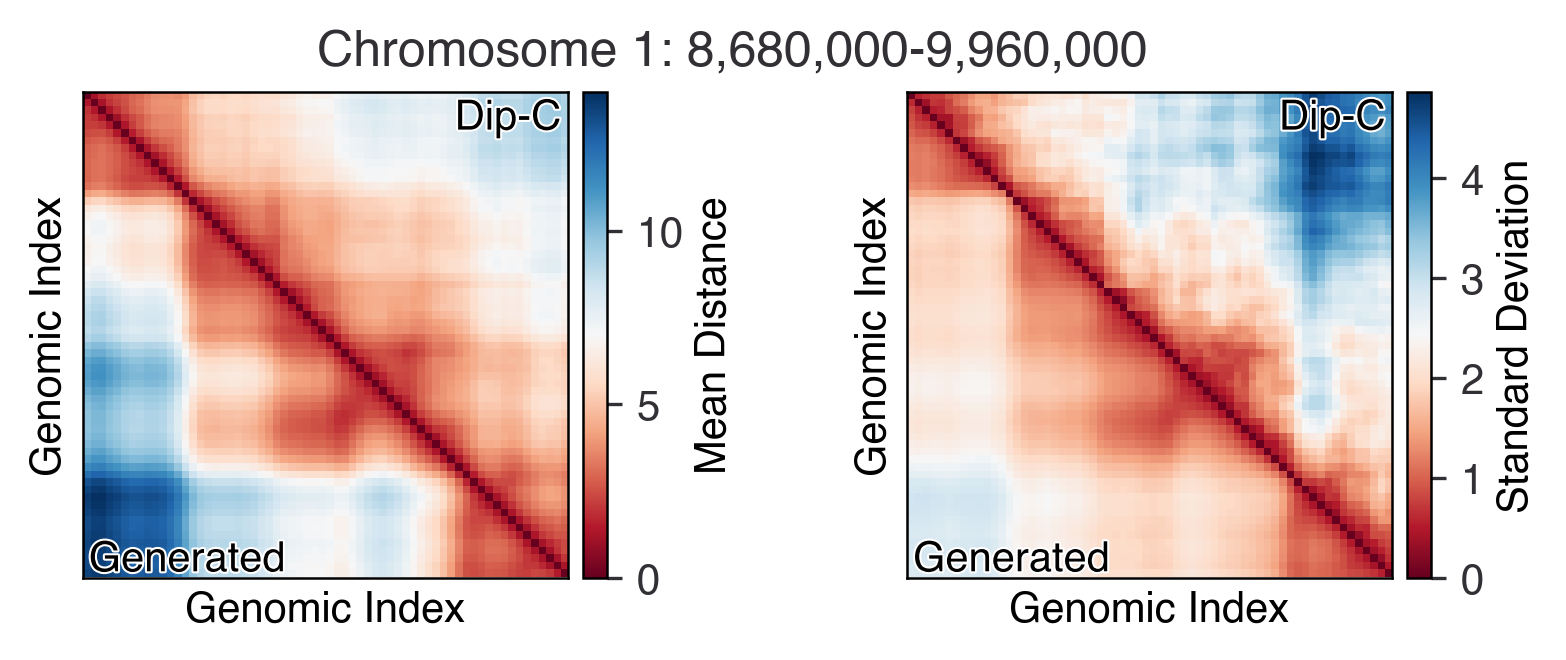

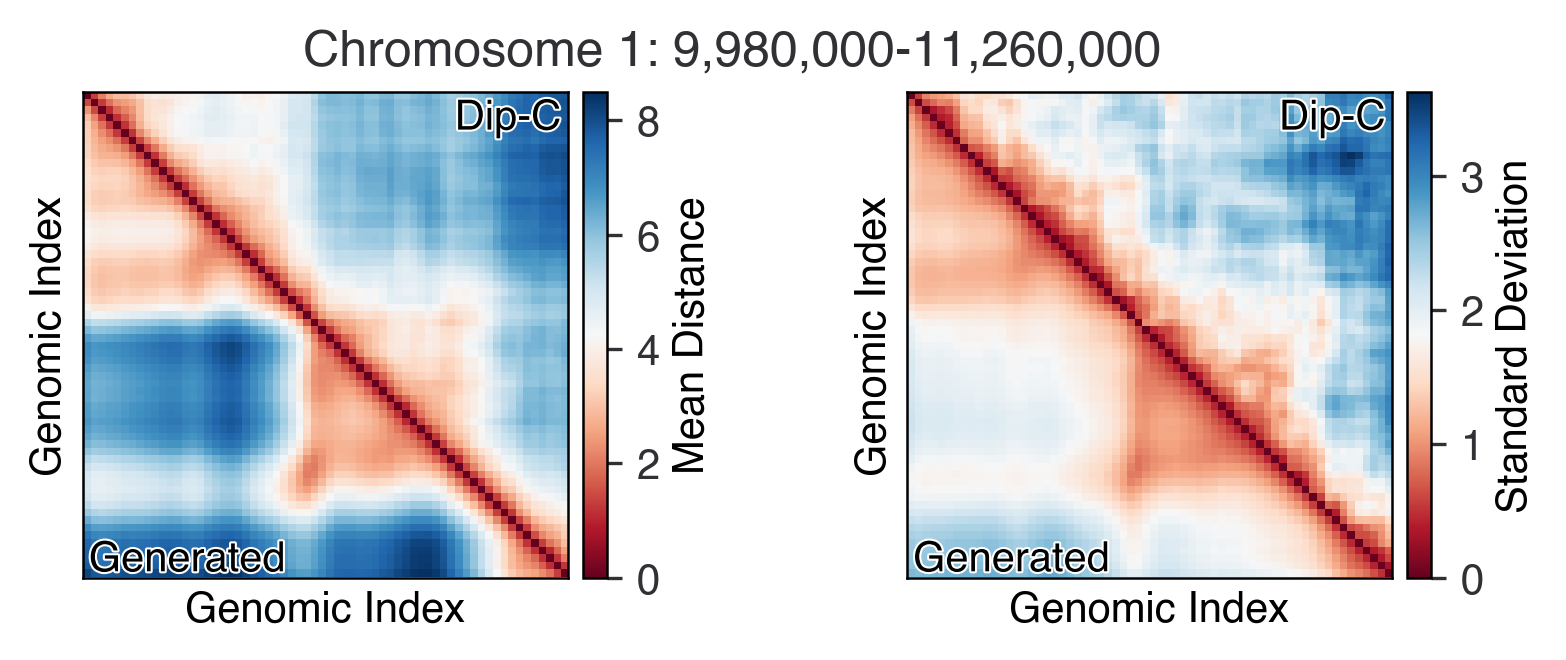

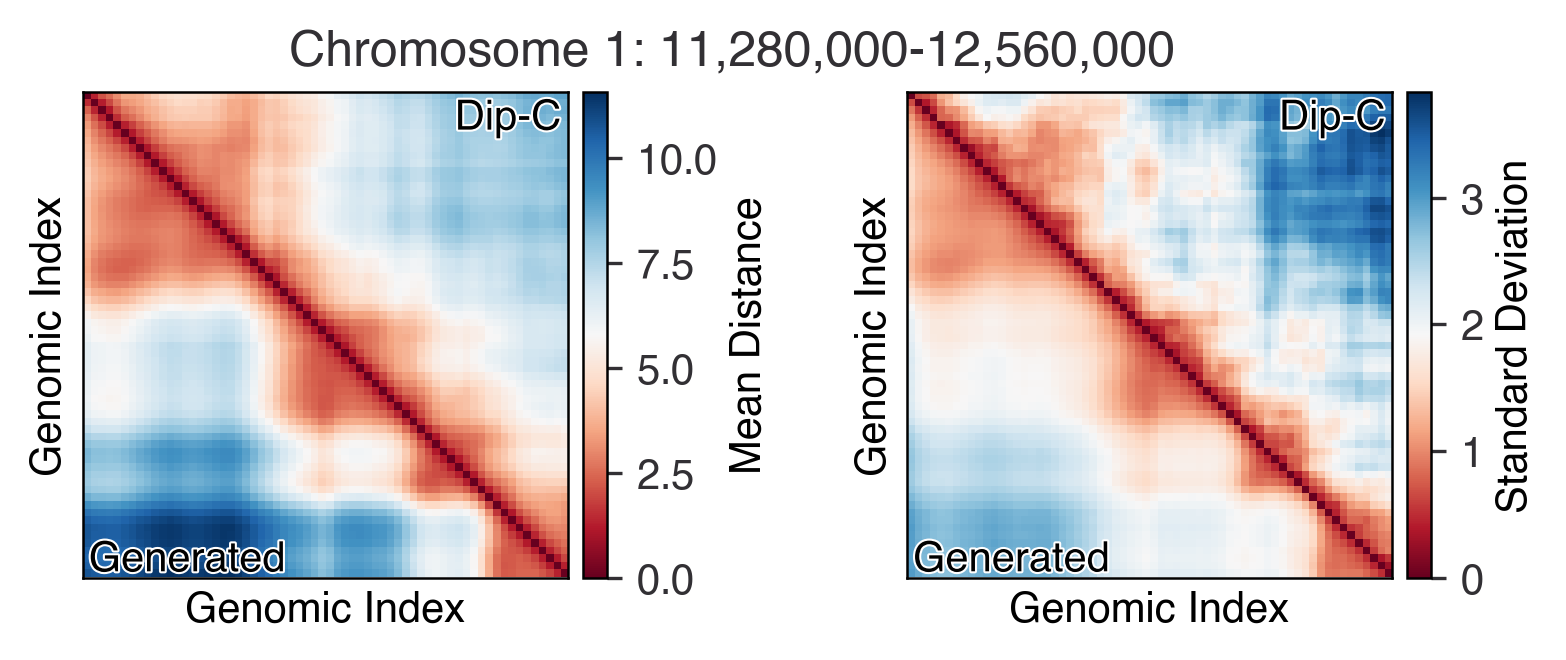

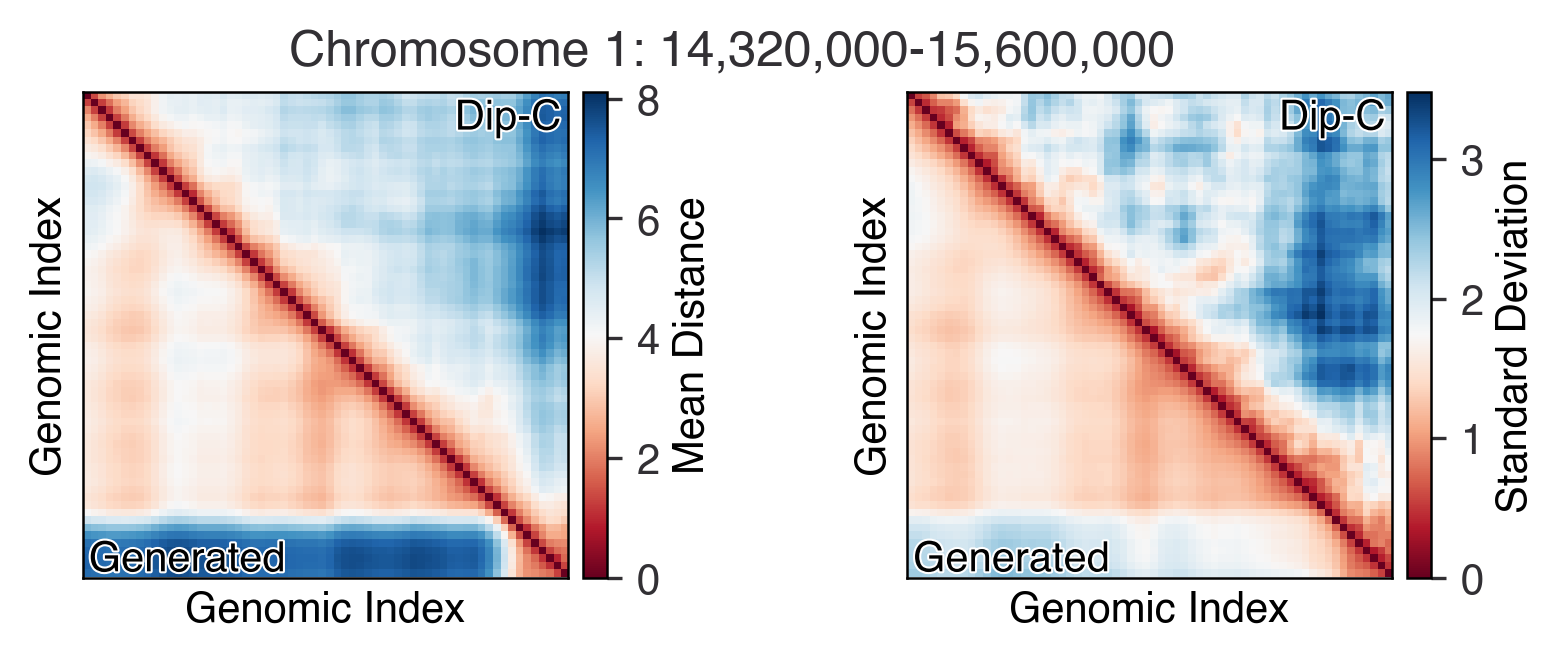

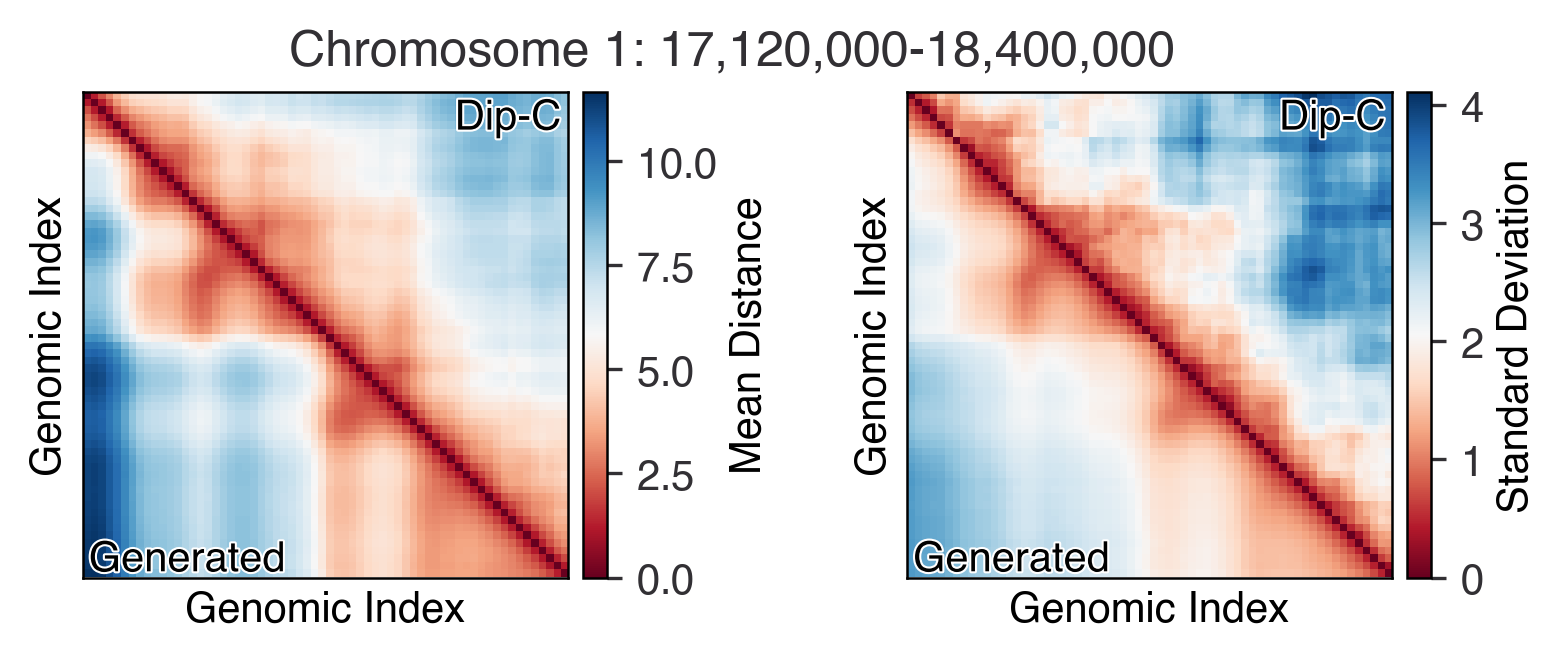

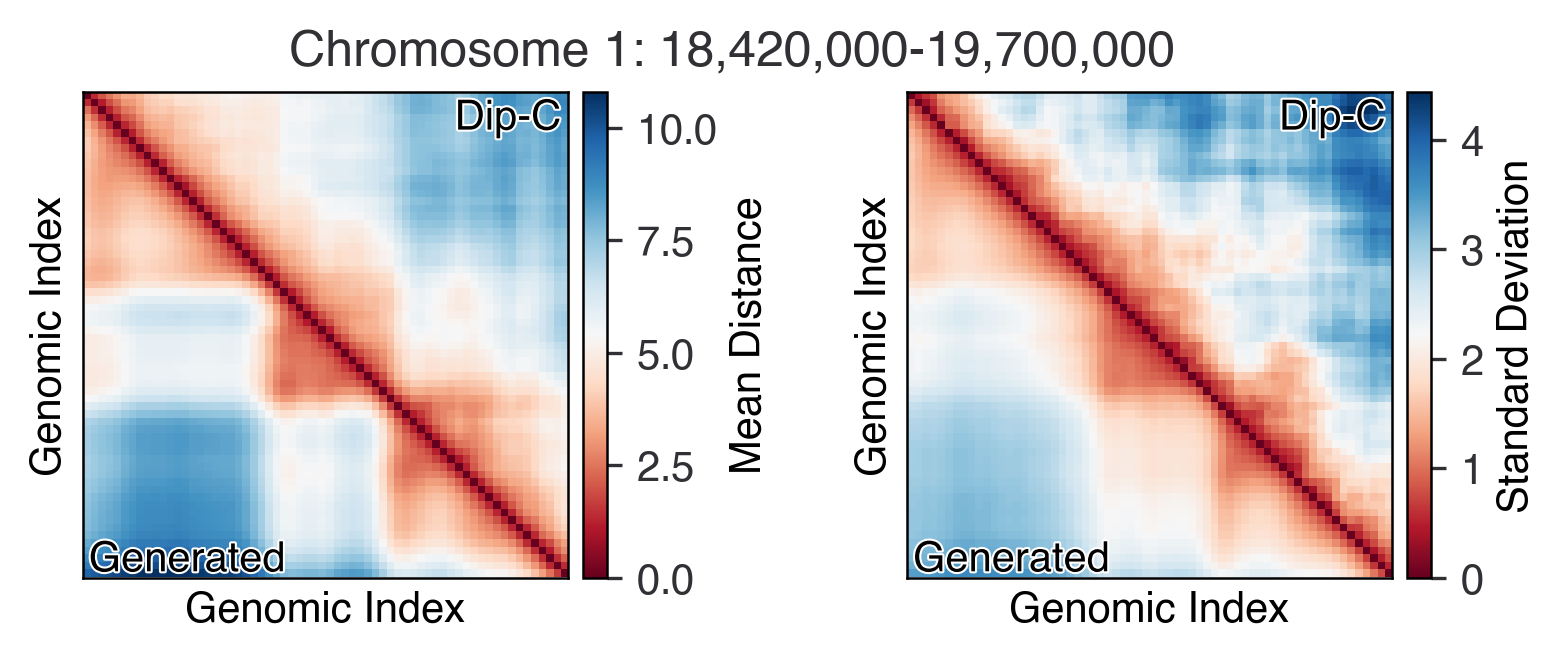

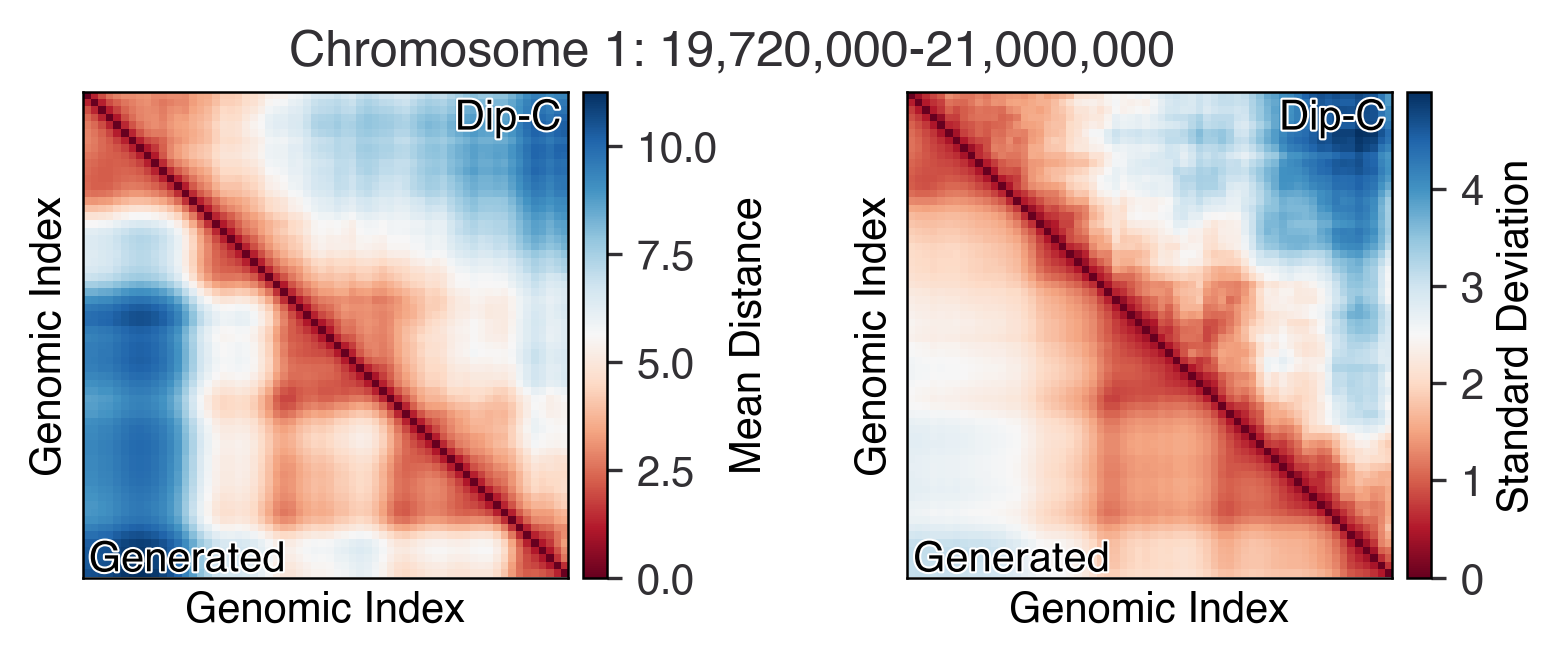

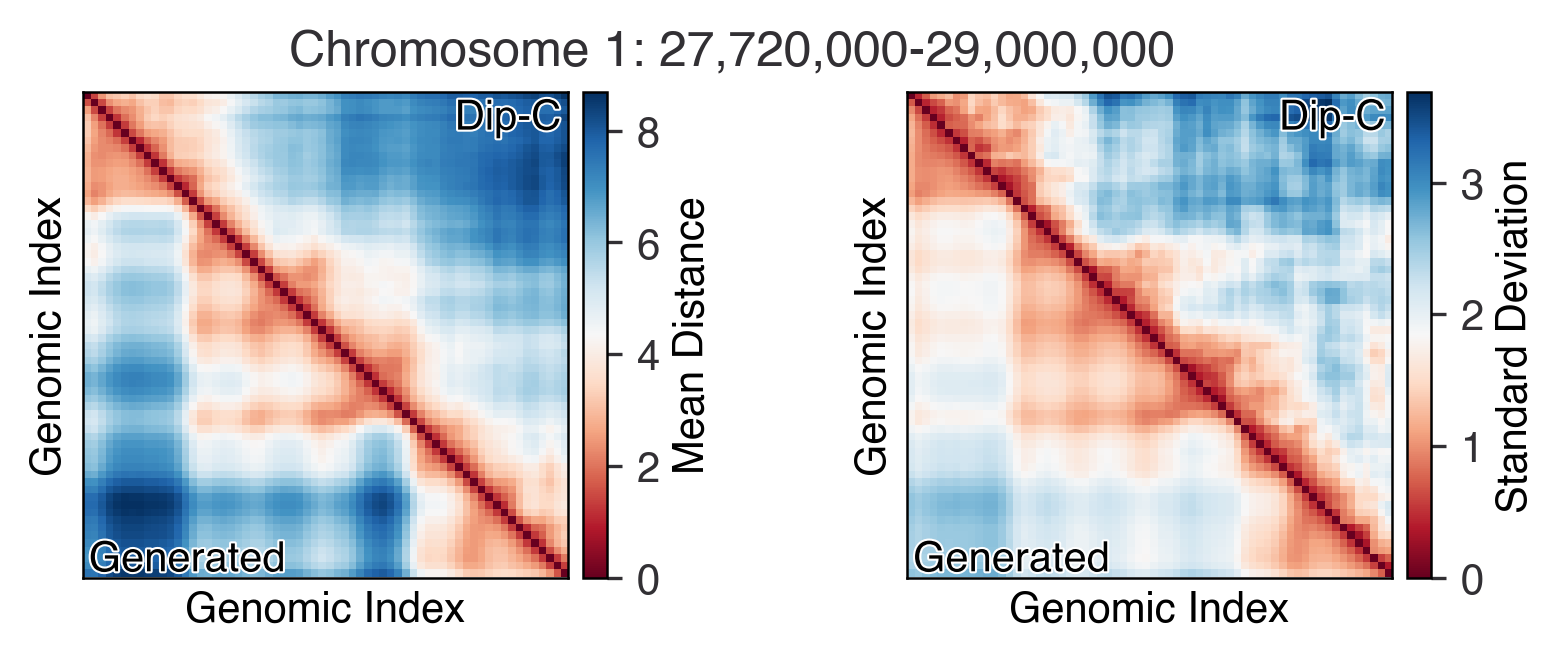

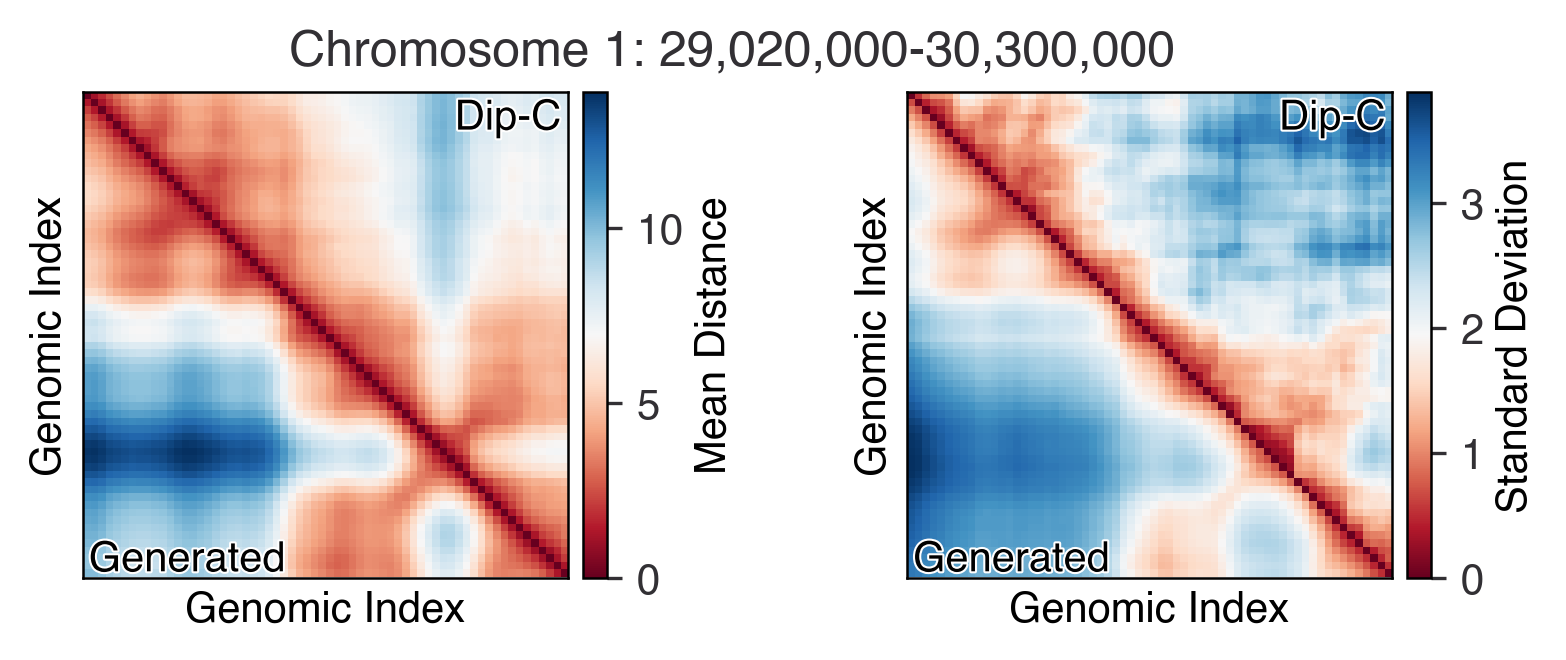

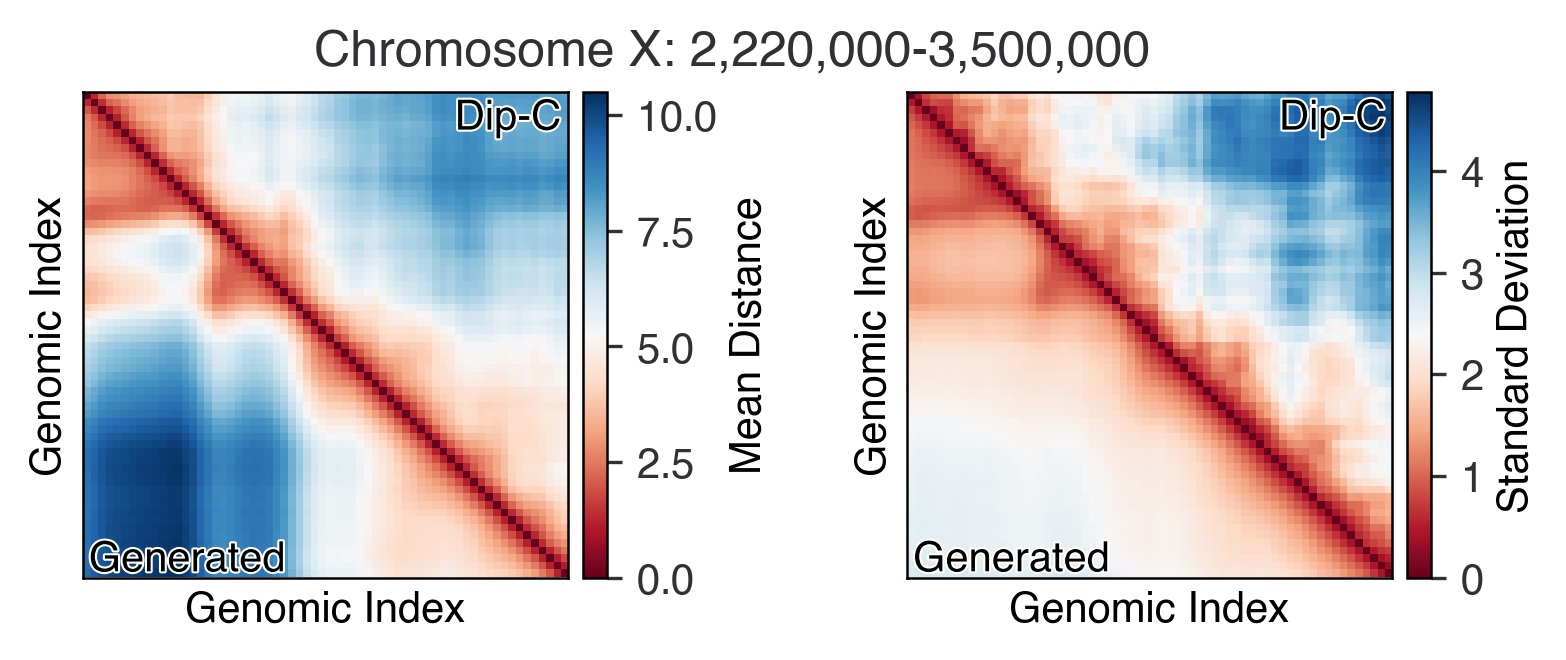

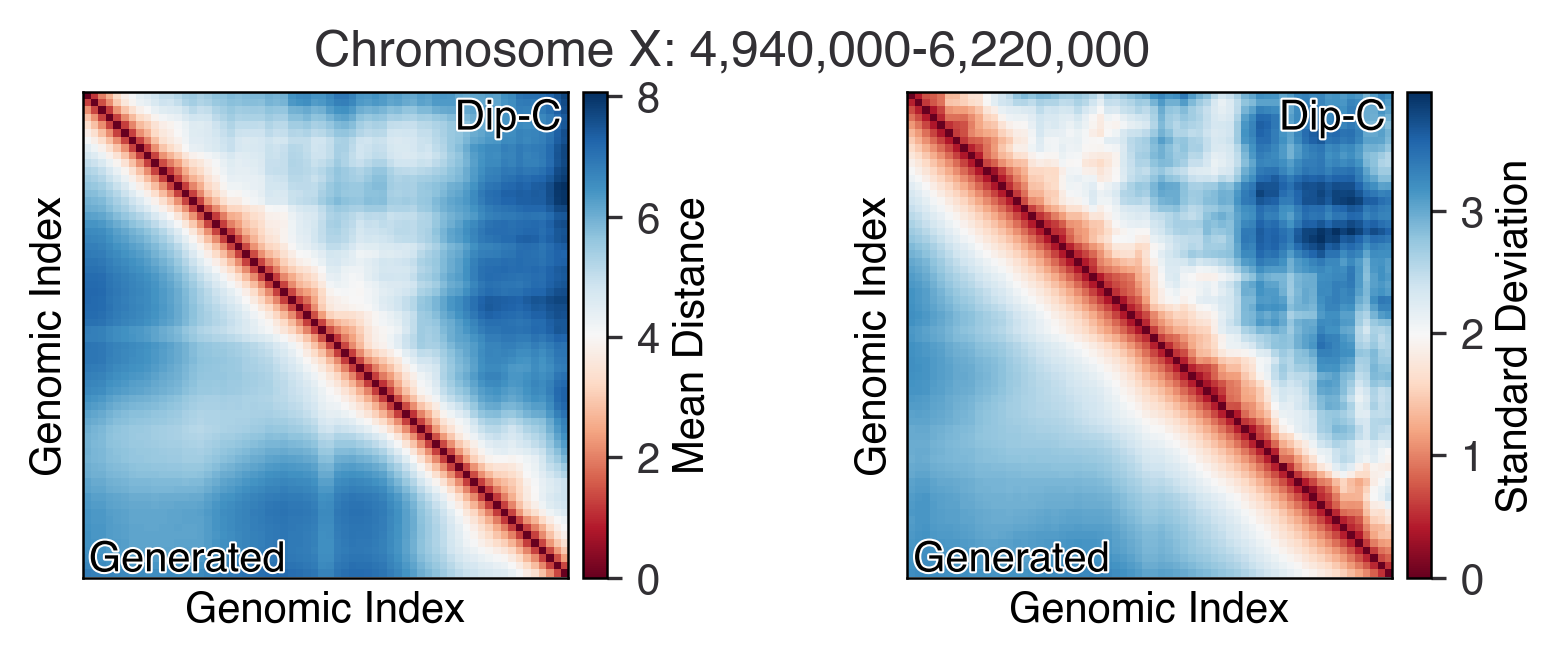

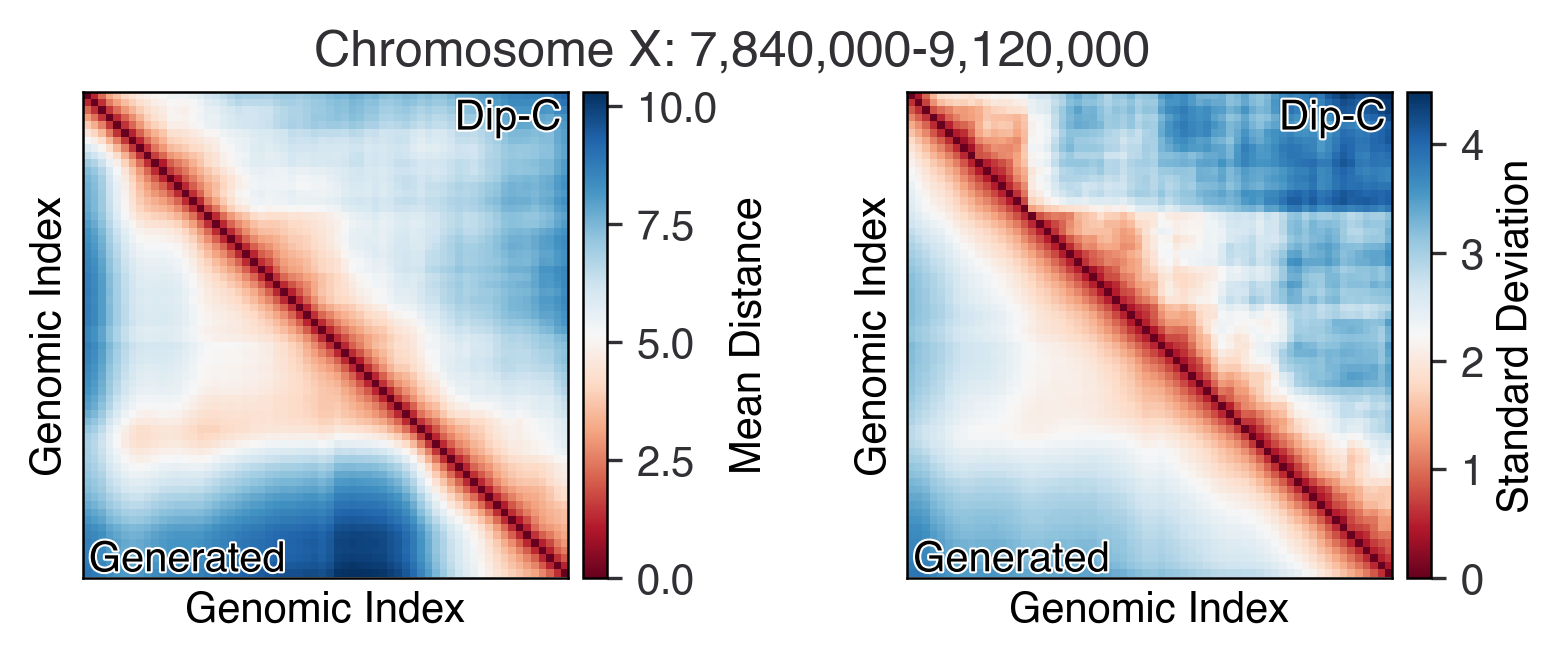

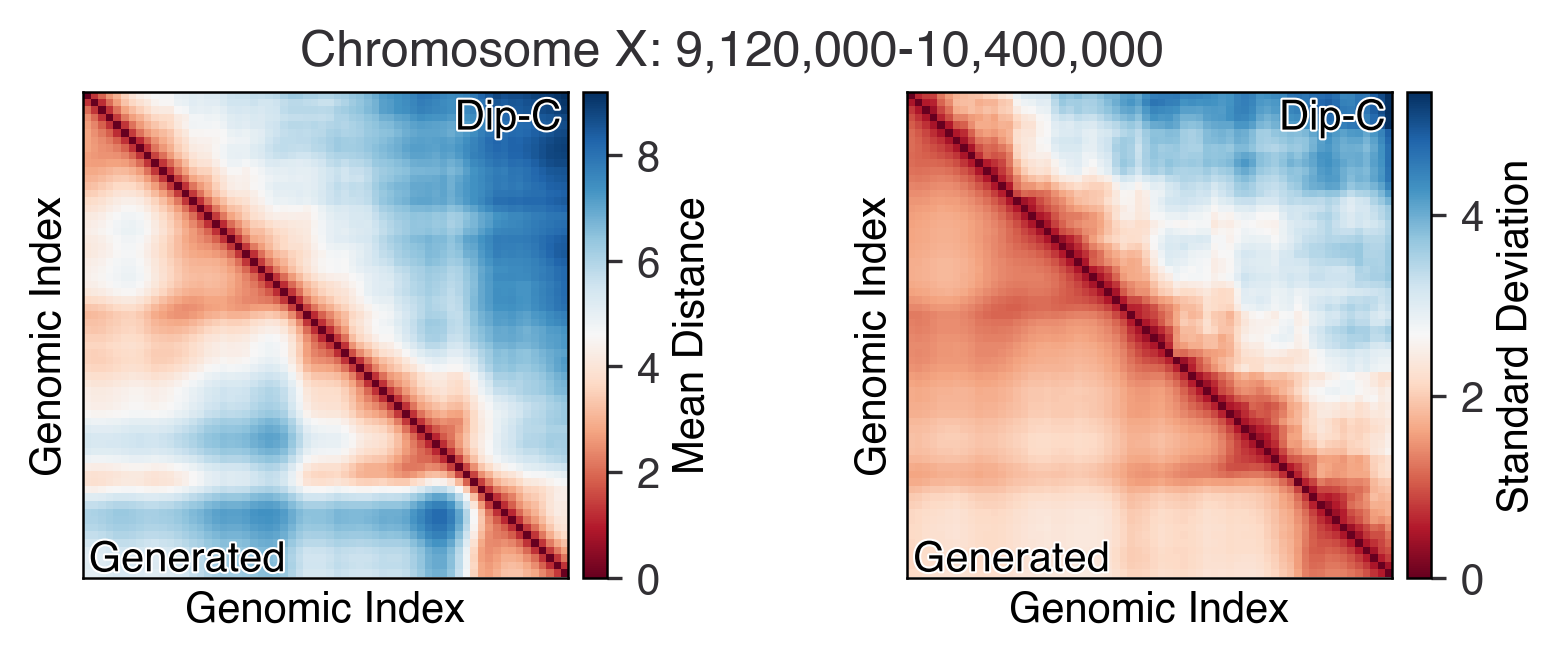

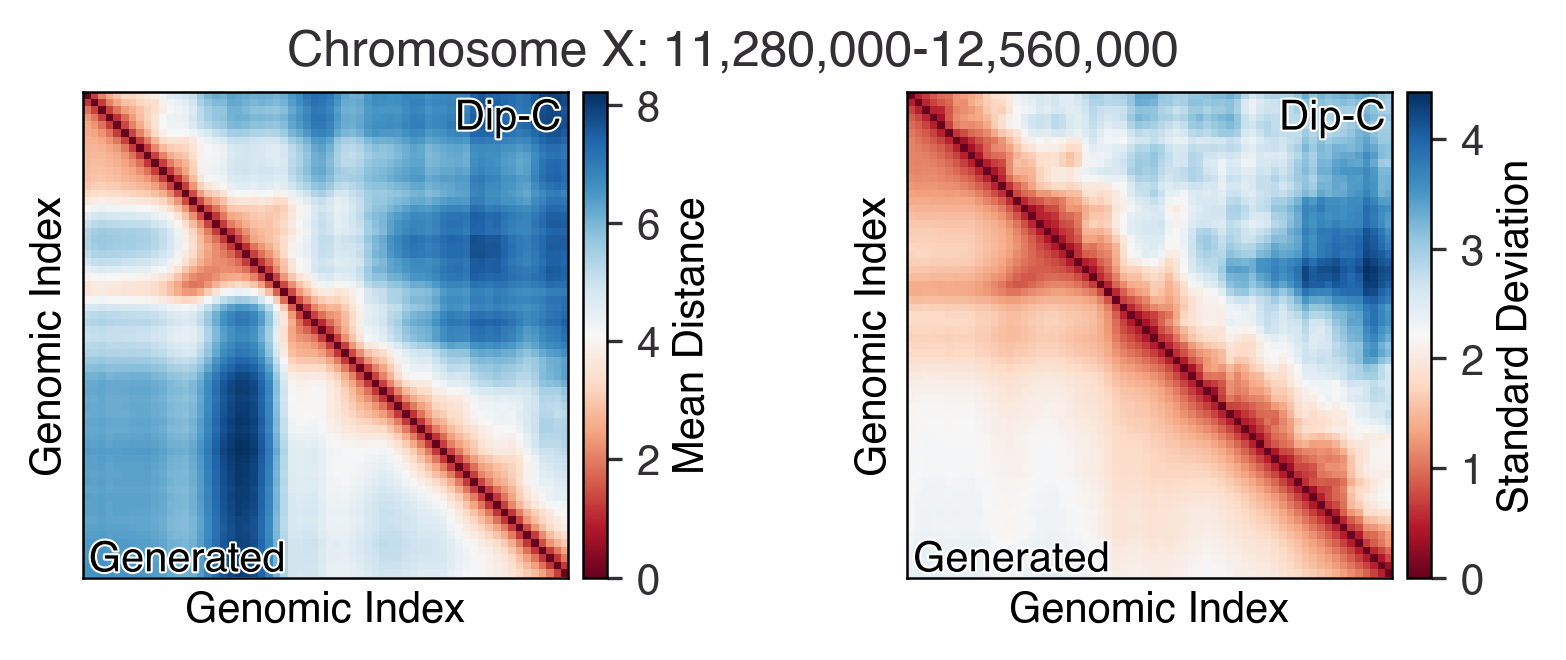

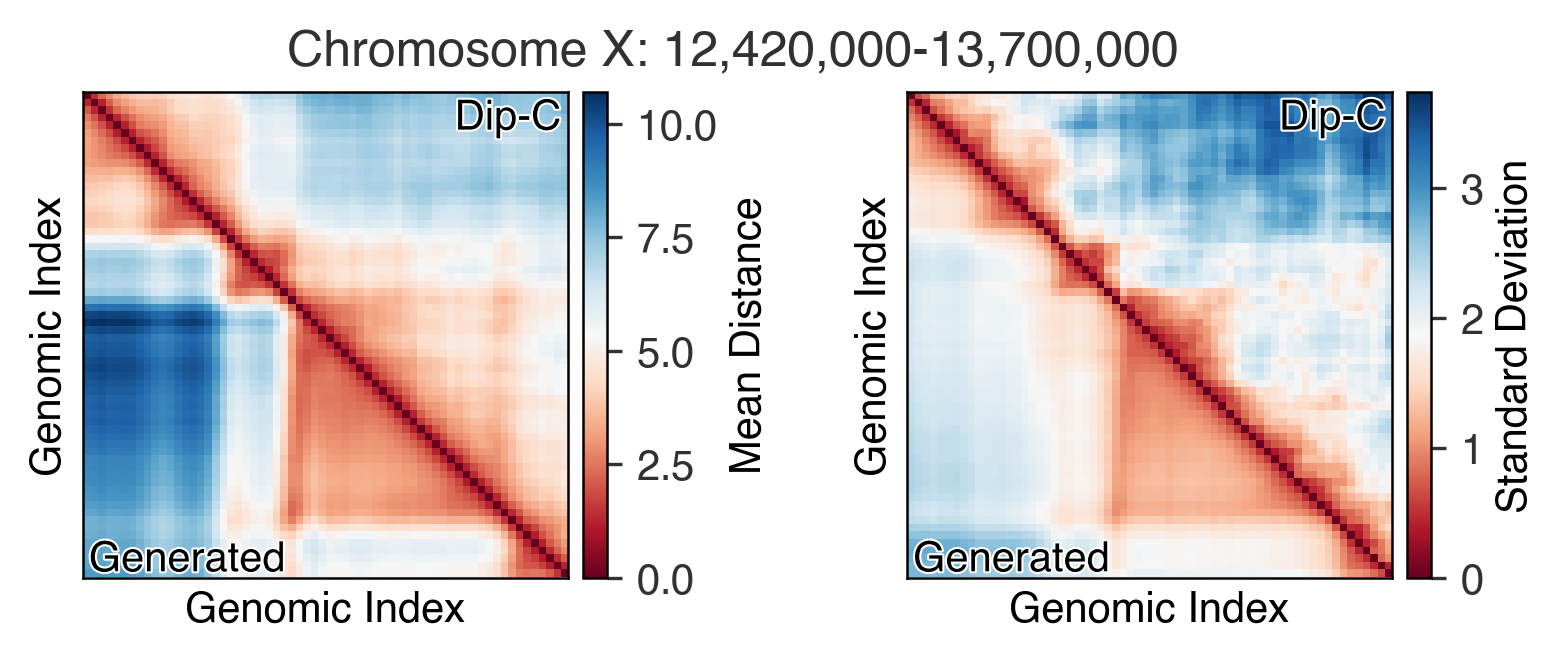

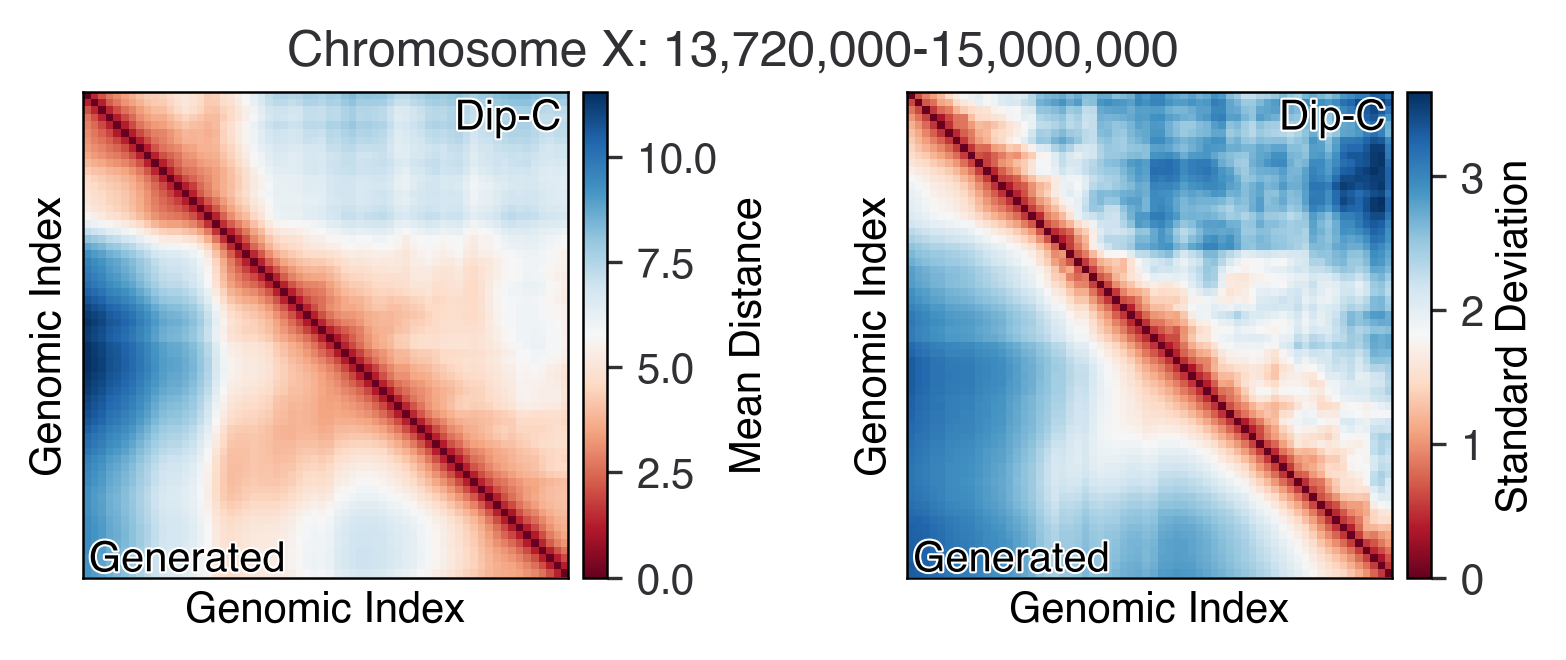

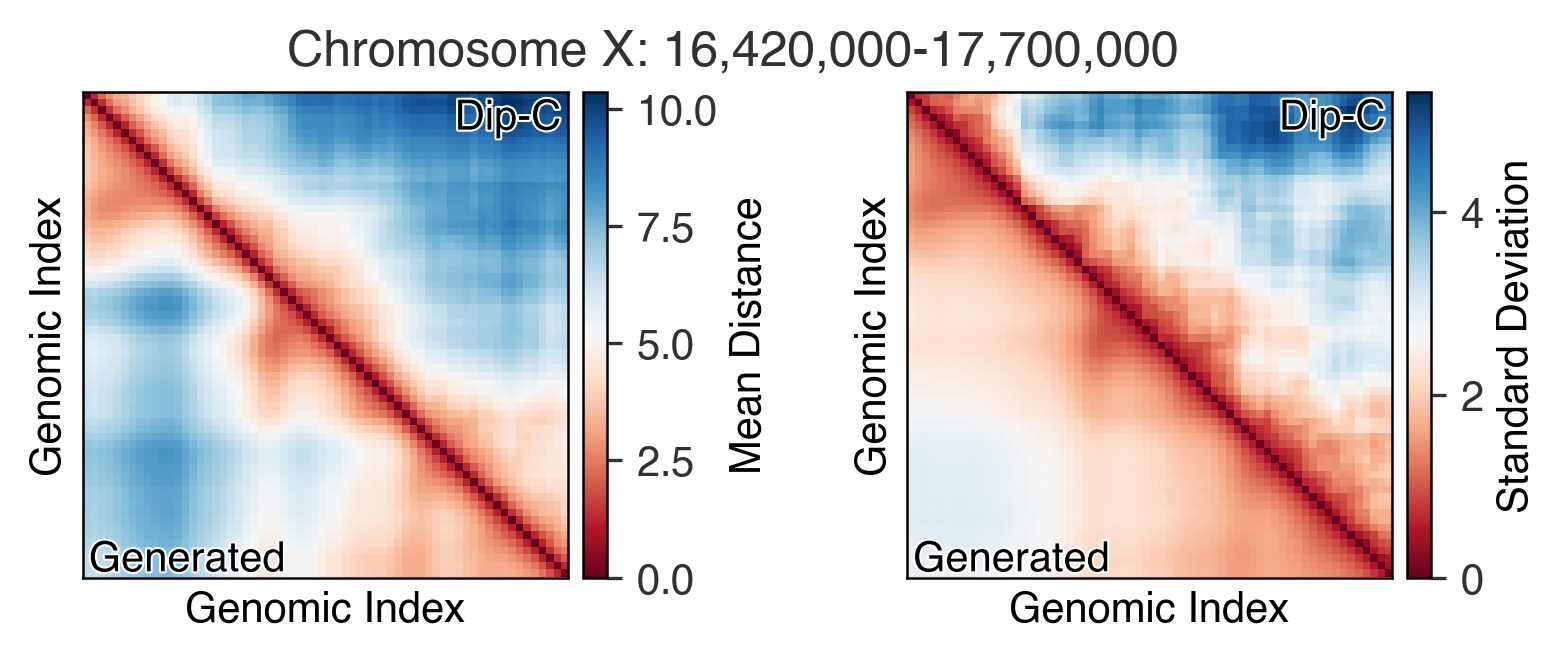

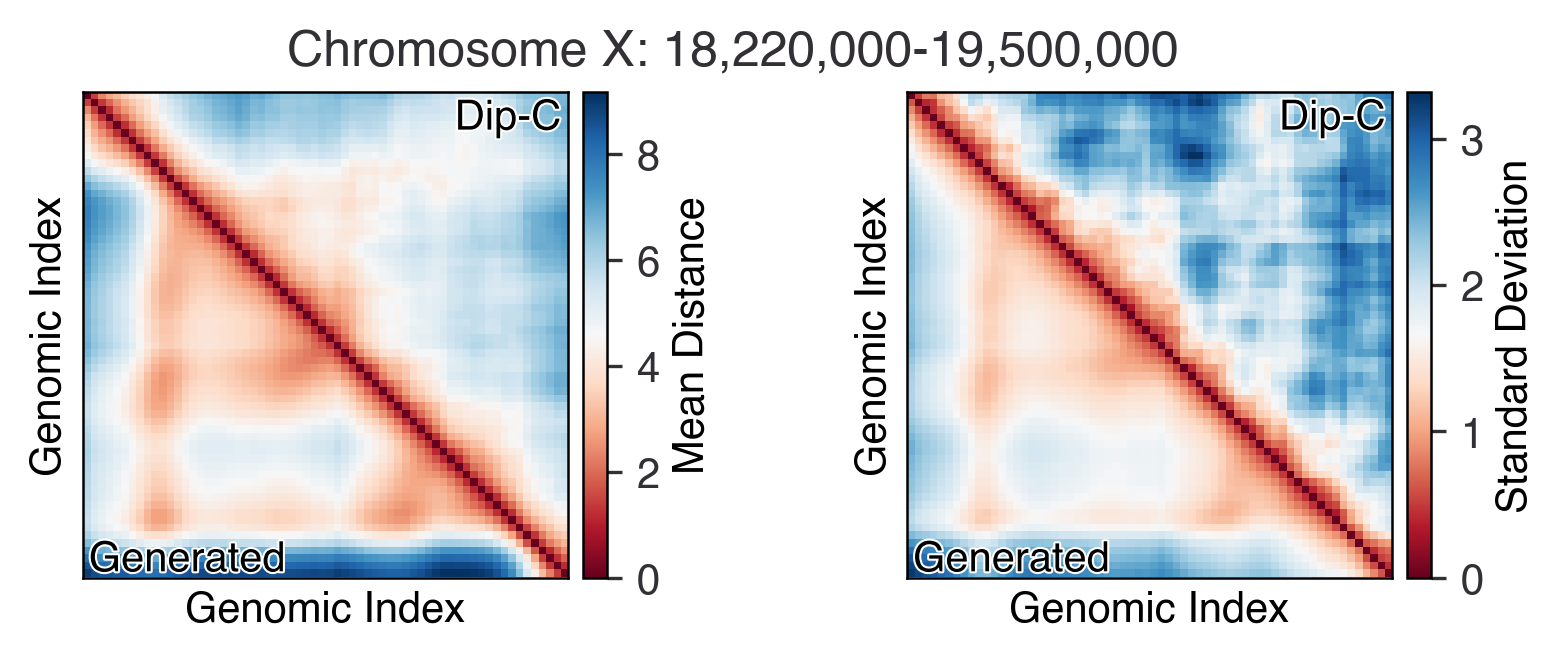

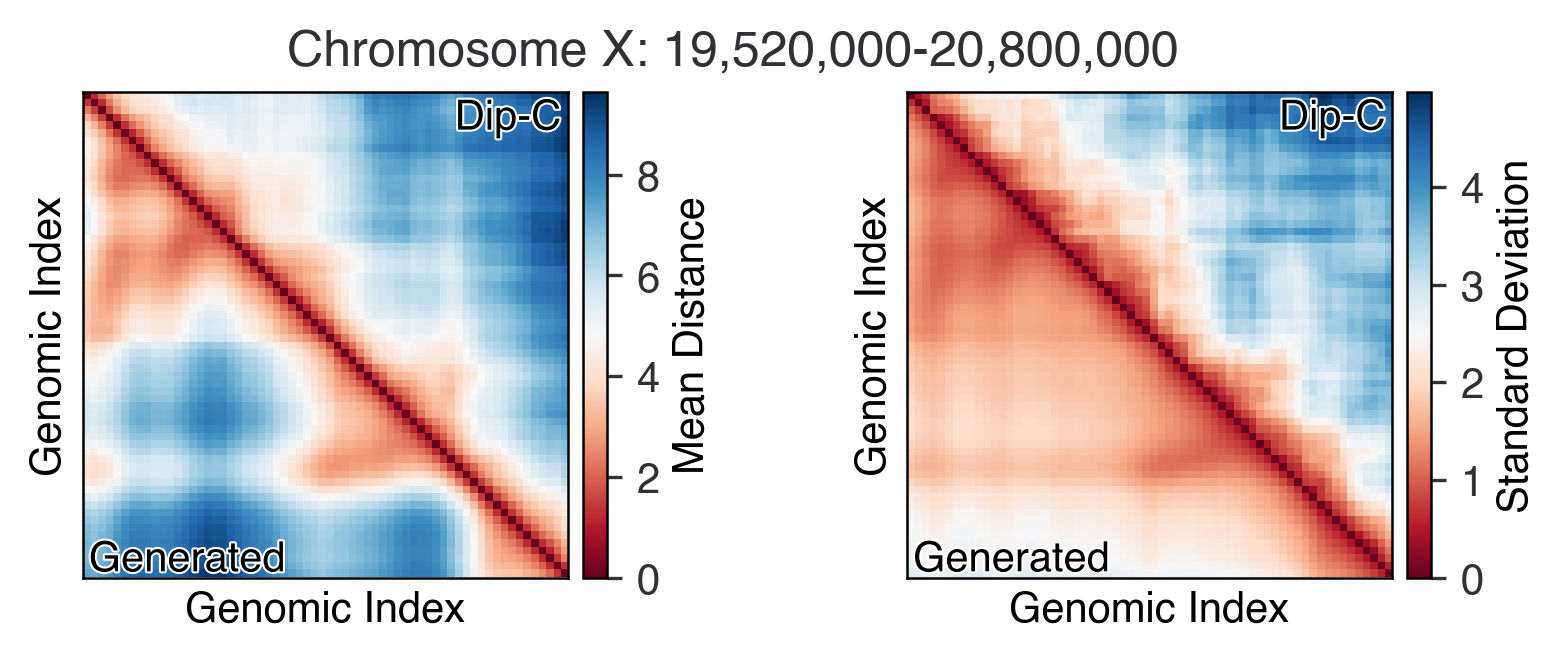

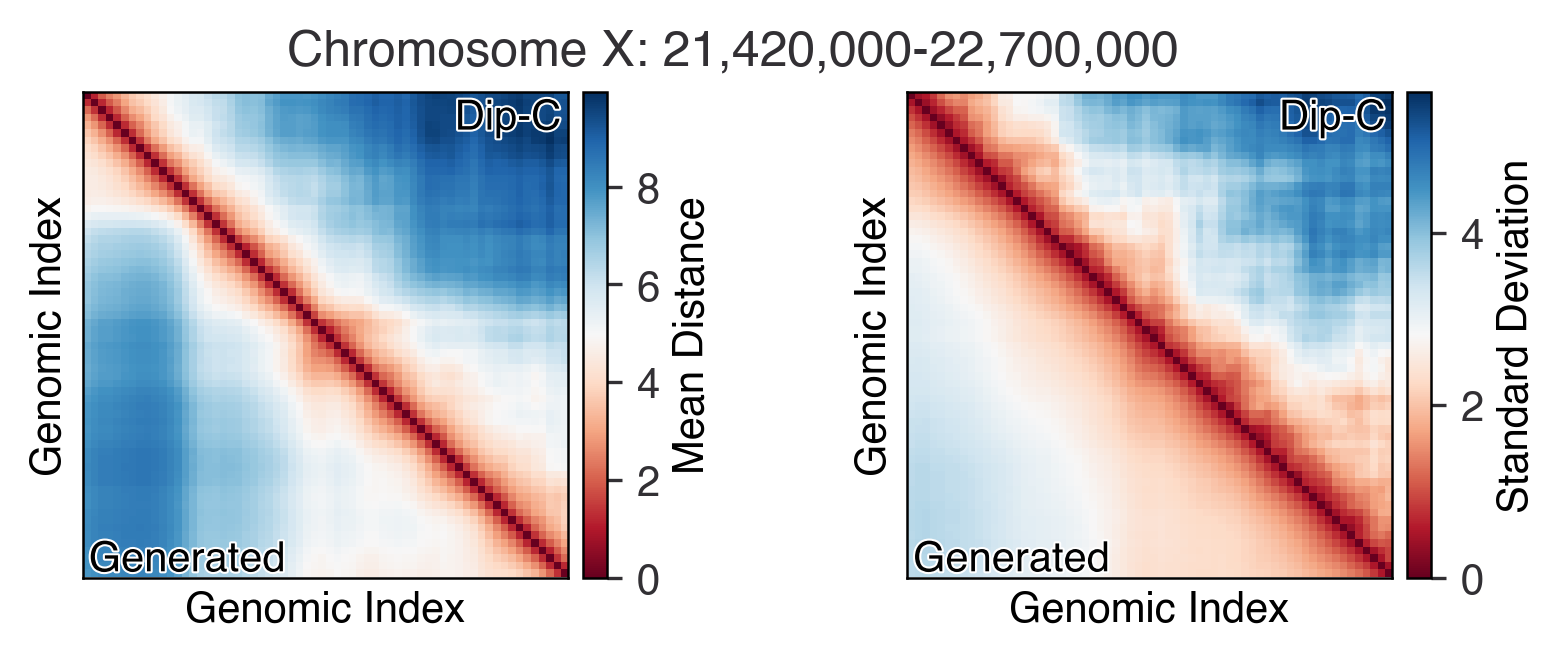

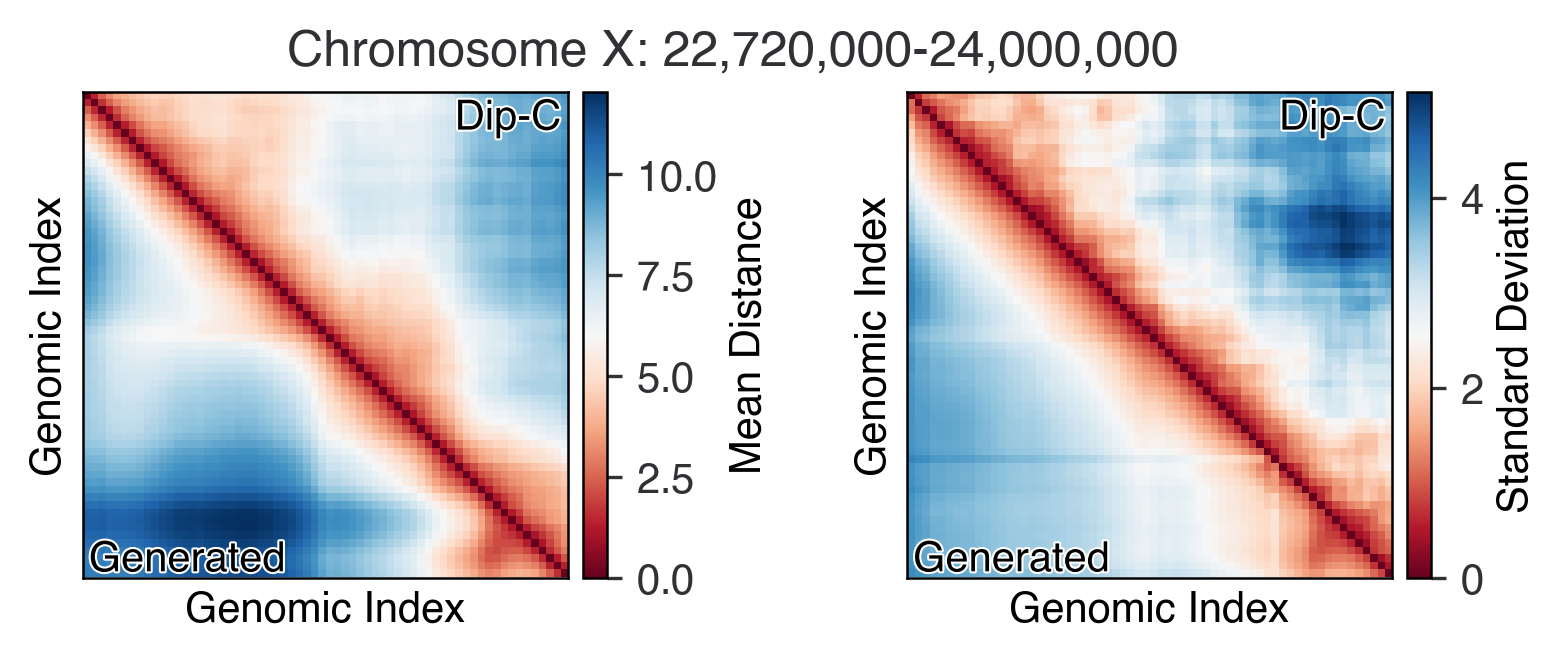

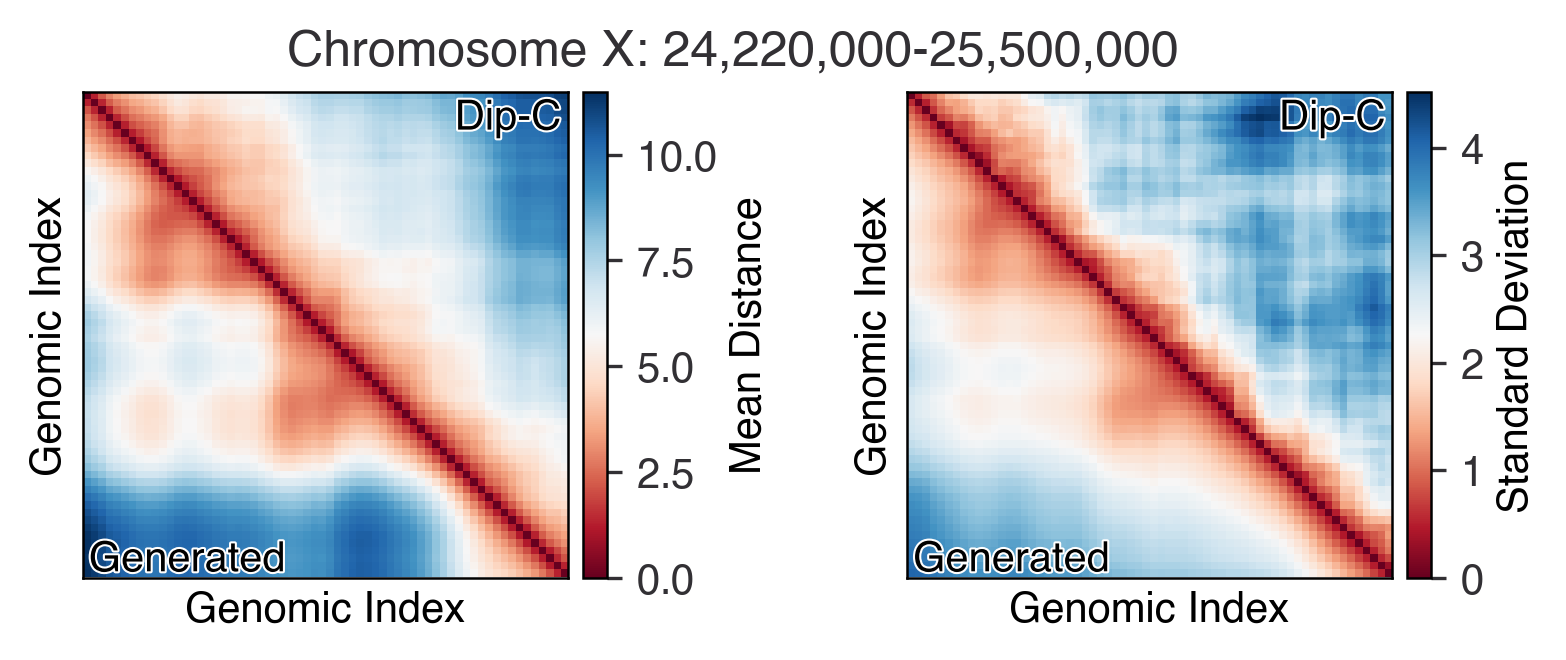

In [9]:
for chrom in regions:
    for region_idx in regions[chrom]:
        try:
            fig,*_ = gen_vs_tan(
                chrom,
                region_idx,
                cond_scale=cond_scale,
                rescaled_phi=rescaled_phi
            )
            fig.savefig(save_dir + f'chrom_{chrom}_region_{region_idx}_nbins_{num_bins}_scale_{cond_scale}_phi_{rescaled_phi}.pdf',bbox_inches='tight')
        except:
            pass

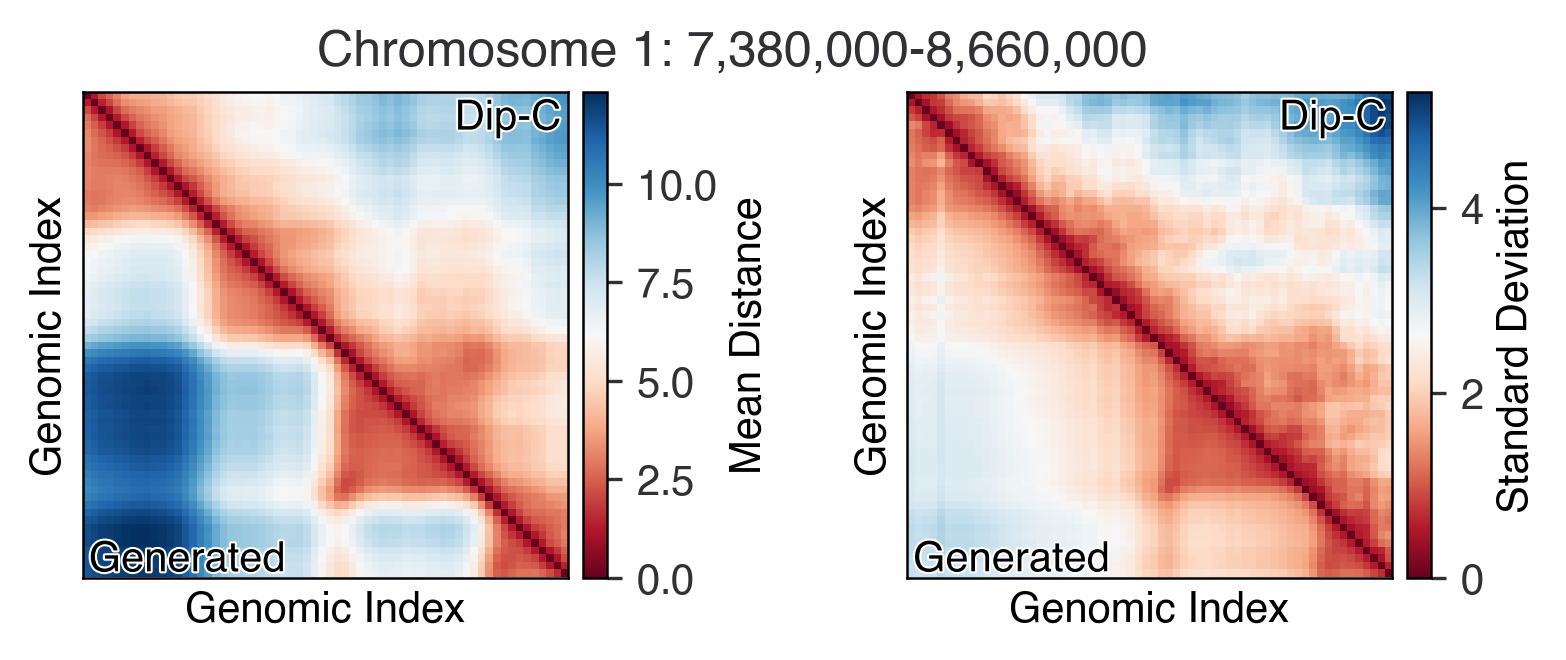

In [10]:
gen_vs_tan(
    '1',
    330,
    cond_scale=5,
    rescaled_phi=8
);

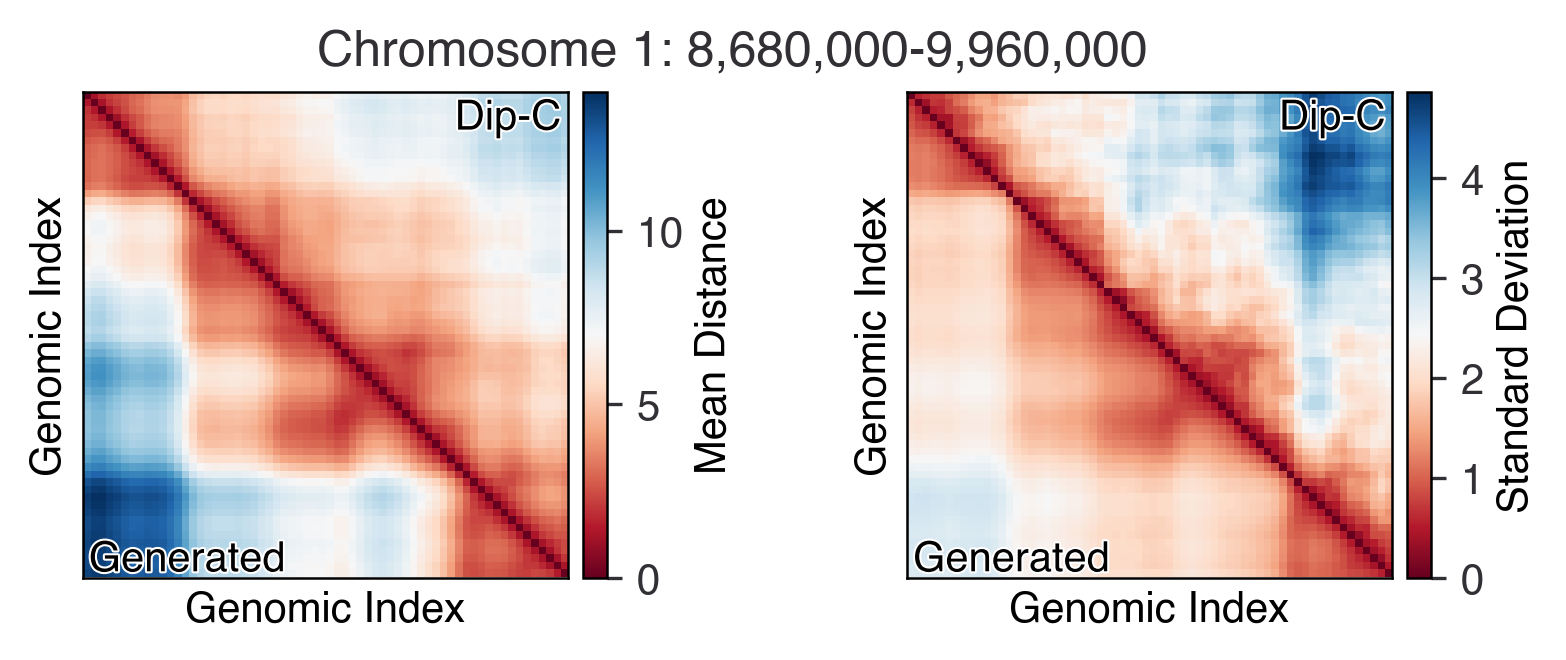

In [11]:
gen_vs_tan(
    '1',
    395,
    cond_scale=5,
    rescaled_phi=8
);

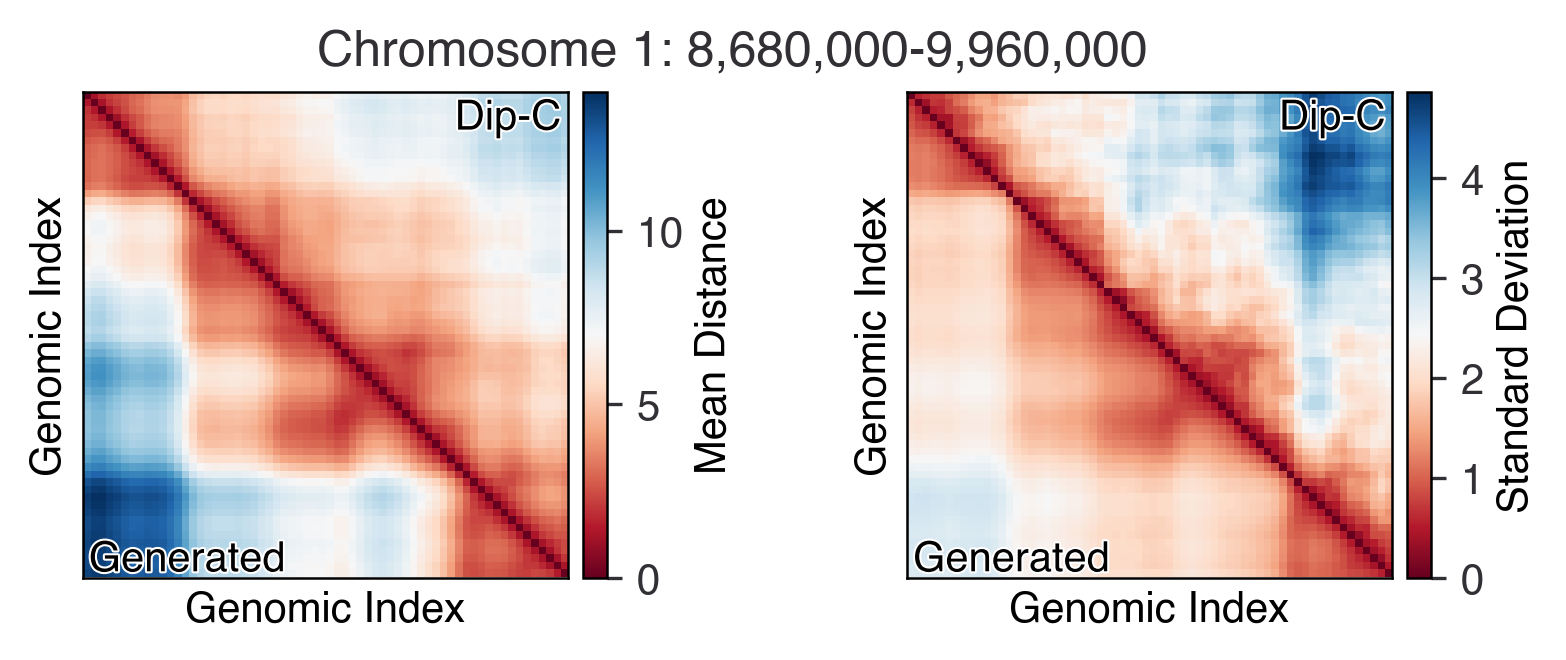

In [12]:
gen_vs_tan(
    '1',
    395,
    cond_scale=5,
    rescaled_phi=8
);